In [6]:
# Import Packages:
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn import hmm
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import PolynomialFeatures

In [7]:
# SPY also captures volatility well. BBUS too, but there is not enough data. Mainly, they are both US ETFs and are not suitable for the argument I want to make.
# https://www.ishares.com/us/products/239623/ishares-msci-eafe-etf
# is composed of large- and mid-cap developed market equities, excluding the US and Canada.

etf = yf.download('EFA', start='2000-01-01', end='2024-09-10')
print(etf)
etf = etf[['Adj Close', 'Volume']] #Using adjusted close (transformed into daily returns) and volume. What other feature of the set can describe volatility?
print(etf)

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2001-08-27  42.916668  42.916668  42.759998  42.833332  23.309155     44700
2001-08-28  42.533333  42.583332  42.263332  42.343334  23.042509    319800
2001-08-29  42.450001  42.466667  42.099998  42.150002  22.937302    128400
2001-08-30  41.666668  41.666668  41.433334  41.549999  22.610786     36900
2001-08-31  41.533333  41.716667  41.466667  41.650002  22.665215   1656900
...               ...        ...        ...        ...        ...       ...
2024-09-03  82.559998  82.660004  81.470001  81.669998  81.669998   9886700
2024-09-04  81.070000  81.690002  80.980003  81.309998  81.309998  10324400
2024-09-05  81.410004  81.559998  80.970001  81.330002  81.330002  12147400
2024-09-06  81.120003  81.330002  79.669998  79.800003  79.800003  12344400
2024-09-09  80.410004  80.900002  80.400002  80.599998  80.599998  10635000

[5794 rows 

In [23]:
# Initiate HMM instance
hmm_1 = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=3000)

In [24]:
# Transform adjusted close prices to daily returns;
# Remove first adjusted close entry becomes null after the transformation;
# A is our arbitrary Borel set (measurable):
A = np.column_stack([etf['Adj Close'].pct_change()[1:], etf['Volume'][1:]])
print(A[:10])

[[-1.14395154e-02  3.19800000e+05]
 [-4.56579806e-03  1.28400000e+05]
 [-1.42351181e-02  3.69000000e+04]
 [ 2.40717415e-03  1.65690000e+06]
 [-2.28093679e-02  5.70000000e+05]
 [-6.14258253e-03  3.15000000e+04]
 [-2.26617459e-02  2.84700000e+05]
 [-5.90228397e-03  9.99000000e+04]
 [-1.14504014e-02  1.43820000e+06]
 [-4.37576590e-02  1.70400000e+05]]


In [25]:
# Fit model to set A:
hmm_1.fit(A)

GaussianHMM(covariance_type='full', n_components=2, n_iter=3000)

In [26]:
# Predict states through the HMM instantiation above:
hmm_states = hmm_1.predict(A)
print(hmm_states)

[1 1 1 ... 1 1 1]


In [27]:
# Filter states:
hmm_state_0 = hmm_states == 0
hmm_state_1 = hmm_states == 1

In [28]:
# Extract column for convenience:
close_price = etf['Adj Close'][1:]
print(close_price[:10])

Date
2001-08-28    23.042509
2001-08-29    22.937302
2001-08-30    22.610786
2001-08-31    22.665215
2001-09-04    22.148235
2001-09-05    22.012188
2001-09-06    21.513353
2001-09-07    21.386375
2001-09-10    21.141493
2001-09-17    20.216391
Name: Adj Close, dtype: float64


C:\Users\001ke\AppData\Local\Temp\ipykernel_2436\1290762301.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(close_price.index,close_price, marker='*', ms=5, color='black', alpha=0.3, label='EFA Adj. Close')


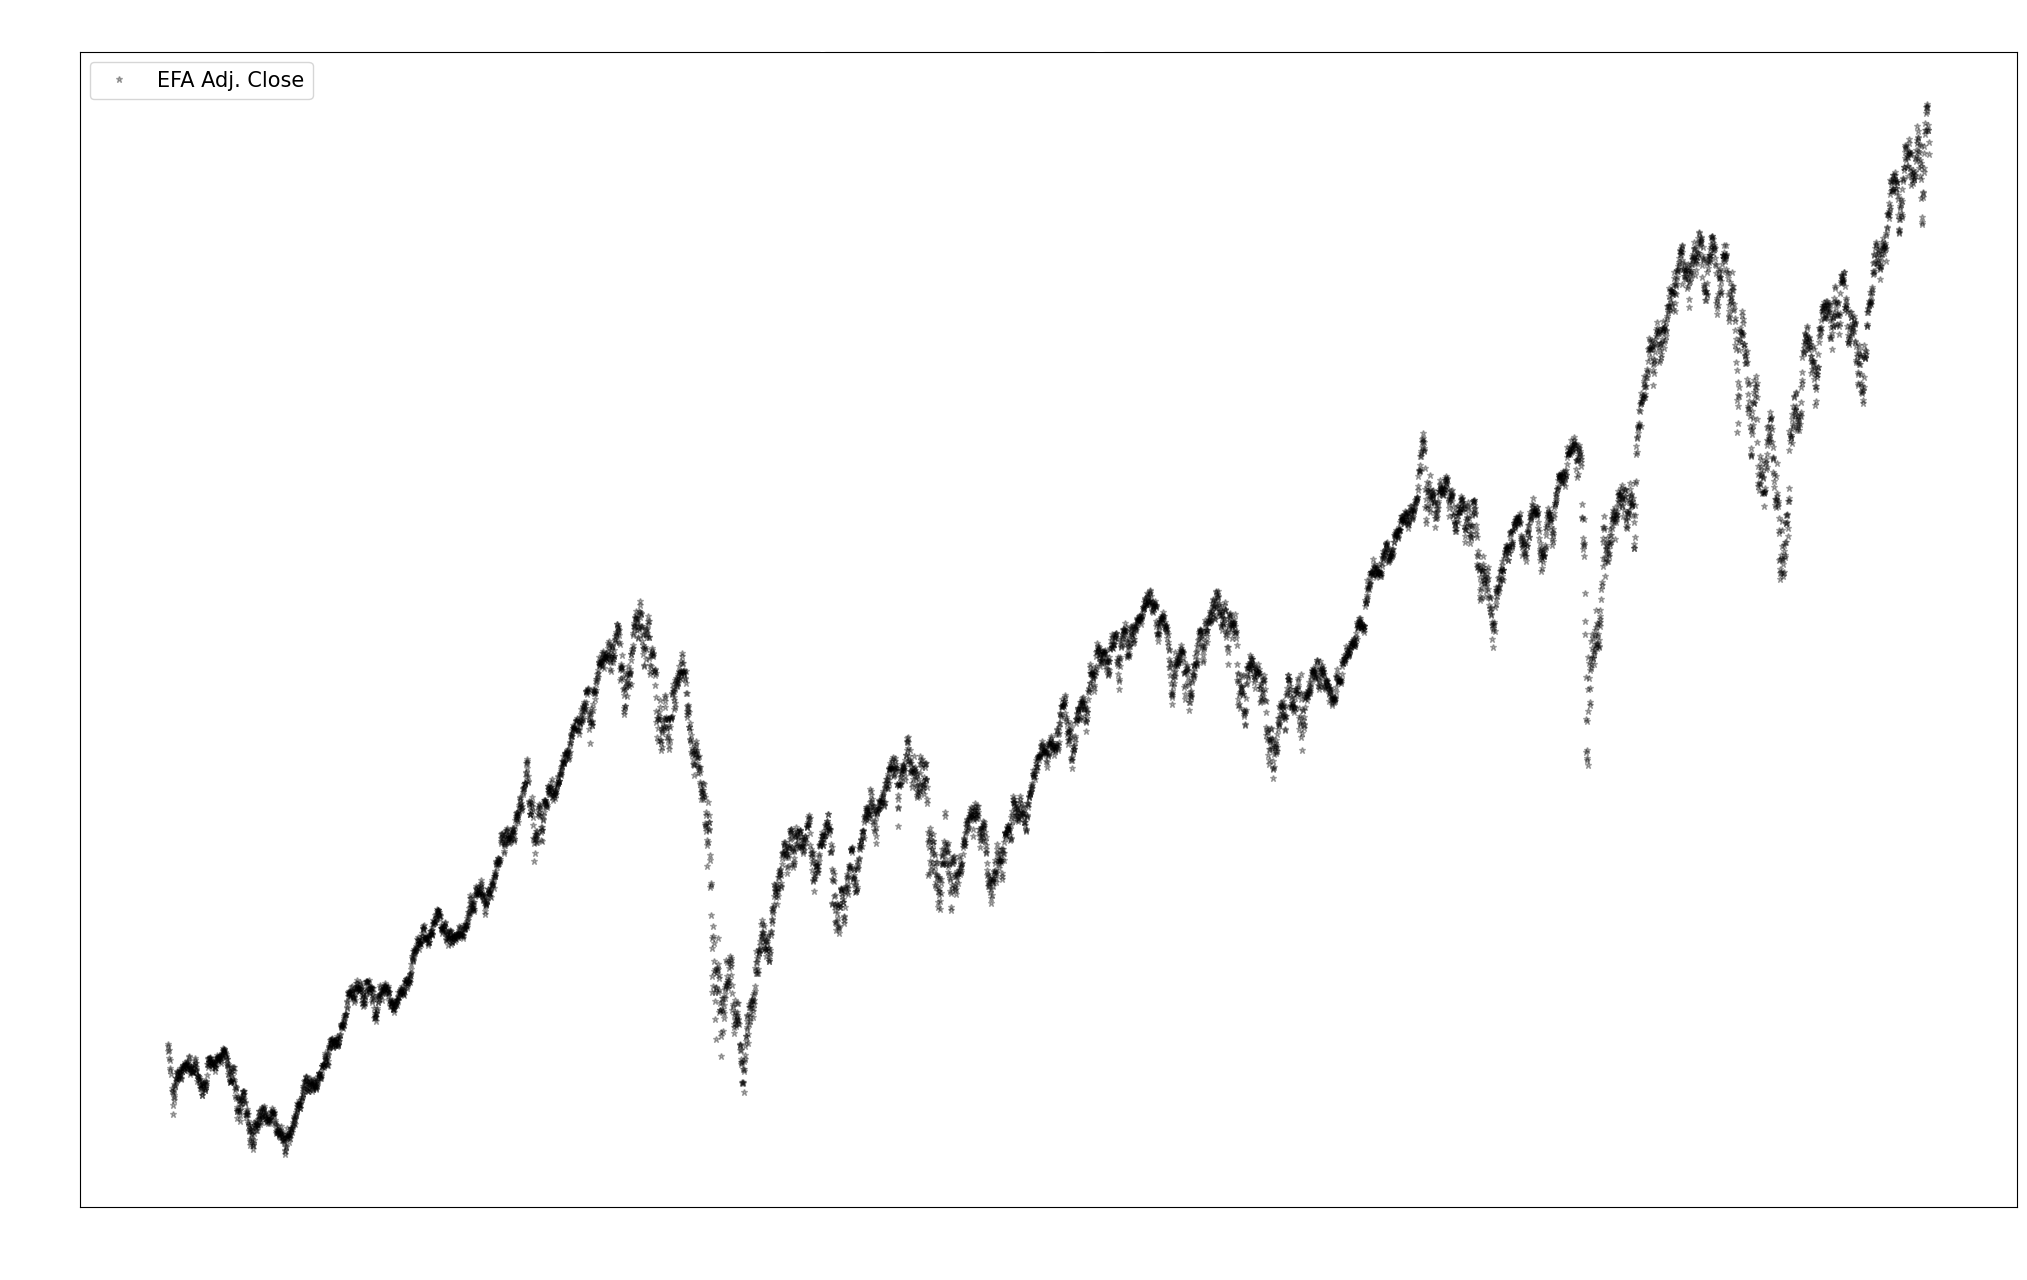

In [29]:
# Plot price data:
default = 'white'
fig = plt.figure(figsize=(25,15))
# Data:
close_price_line = fig.add_subplot(111)
plt.plot_date(close_price.index,close_price, marker='*', ms=5, color='black', alpha=0.3, label='EFA Adj. Close')
# Aesthetic adjustments:
close_price_line.set_title('Adjusted Closing Price, EFA', fontsize=30, color=default)
close_price_line.set_xlabel("Date", fontsize=20, color=default)
close_price_line.set_ylabel("Closing Price", fontsize=20, color=default)
close_price_line.tick_params(axis='both', labelsize=15, colors=default)
close_price_line.legend(loc='upper left', fontsize=15)
# Generate and save graph:
plt.savefig('adj_close_graph.png')
plt.show()

192.05374912730733
248.52709679857034


C:\Users\001ke\AppData\Local\Temp\ipykernel_2436\4053150004.py:11: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(close_price.index[hmm_state_0],close_price[hmm_state_0], marker='*', ms=5, alpha=0.4, label='Hidden State 0')
C:\Users\001ke\AppData\Local\Temp\ipykernel_2436\4053150004.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(close_price.index[hmm_state_1],close_price[hmm_state_1], marker='*', ms=5, alpha=0.4, label='Hidden State 1')


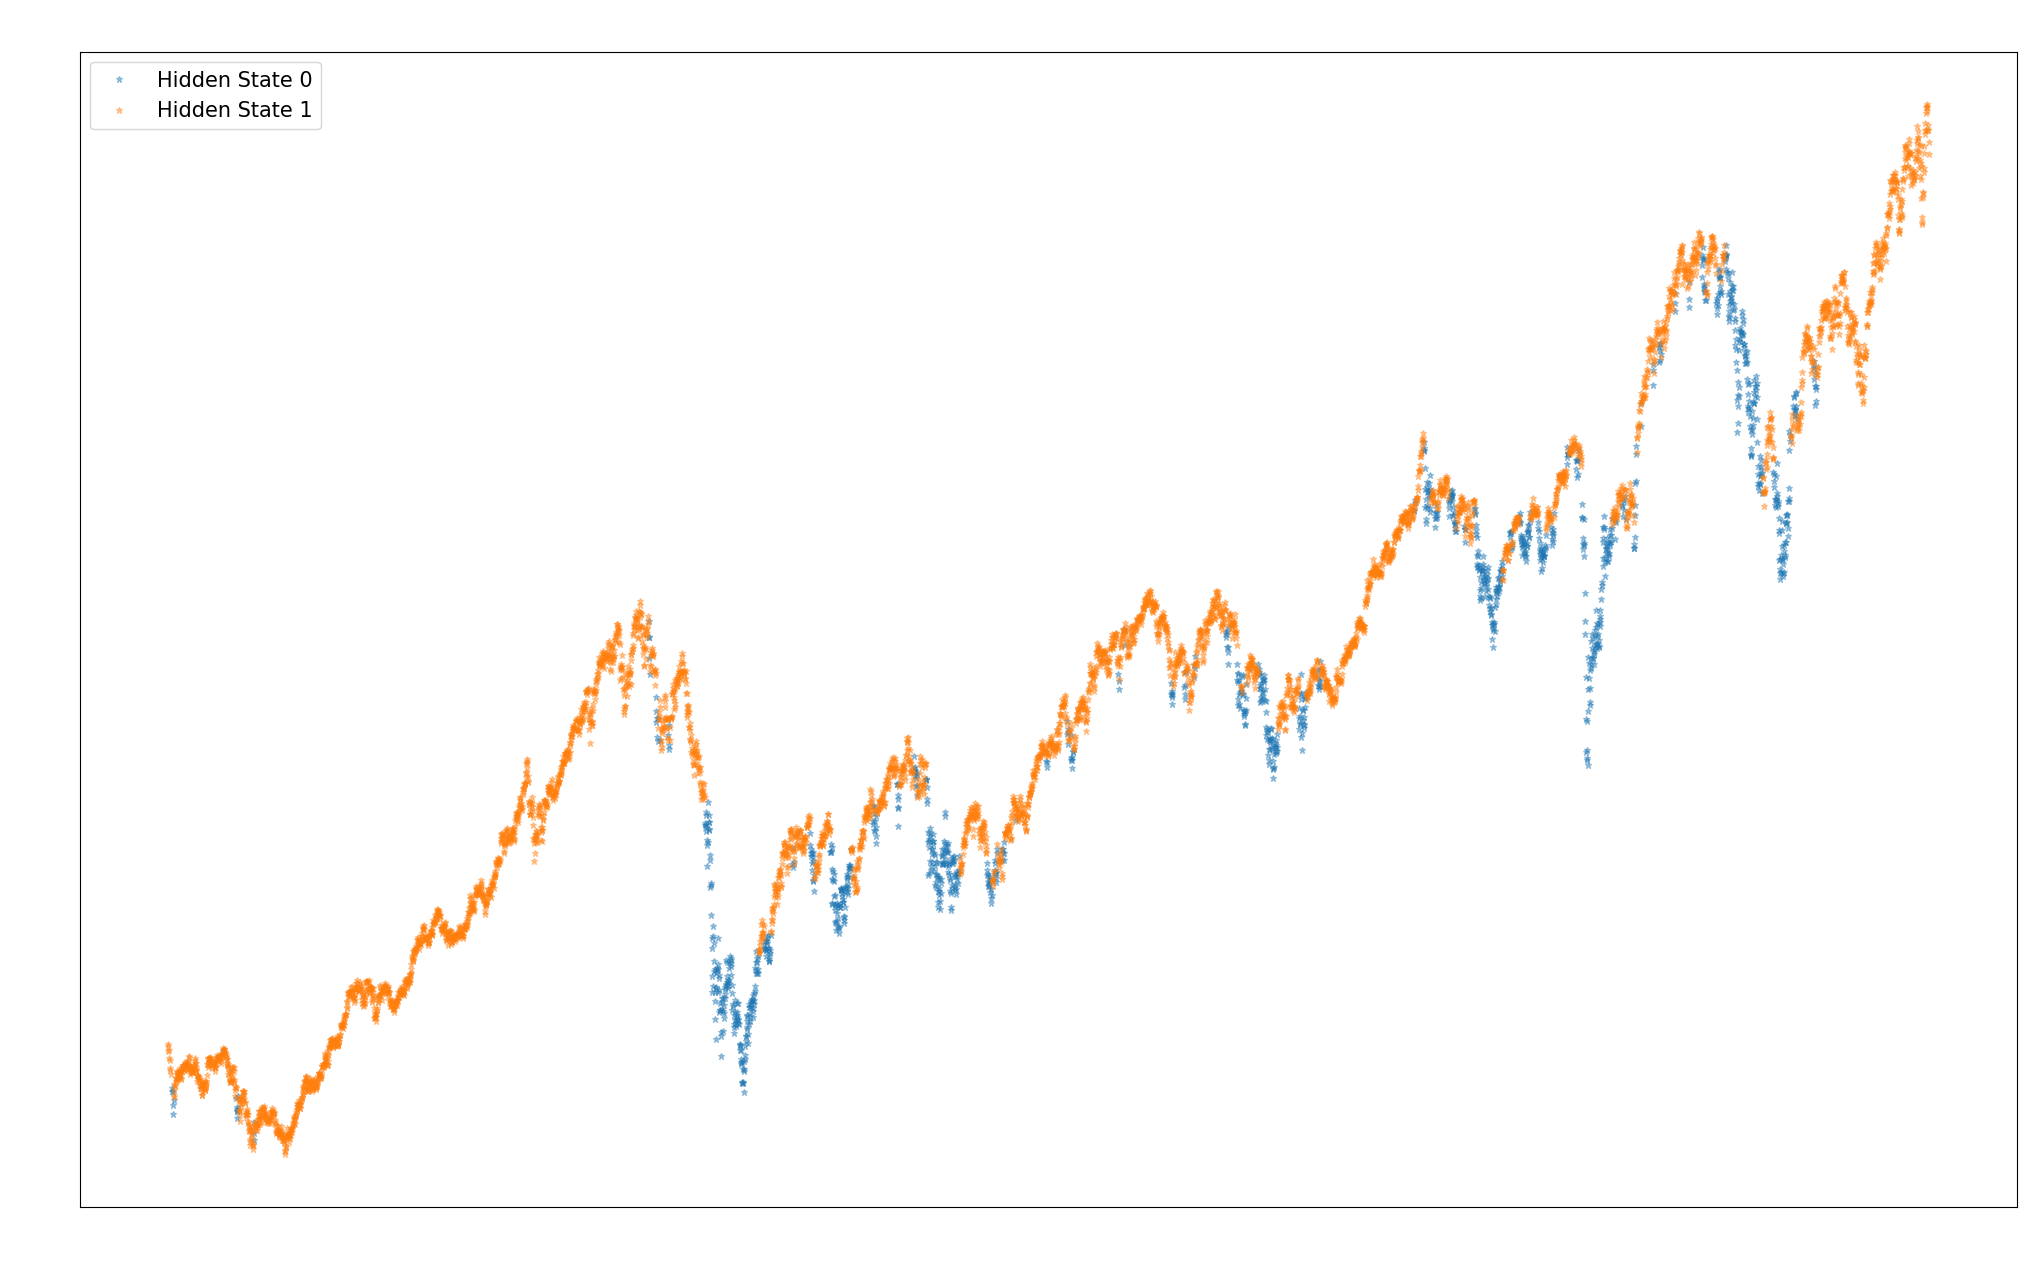

In [30]:
var_hidden_state_0 = np.cov(close_price[hmm_state_0])
print(var_hidden_state_0)
var_hidden_state_1 = np.cov(close_price[hmm_state_1])
print(var_hidden_state_1)

# Plot states:
default = 'white'
fig = plt.figure(figsize=(25,15))
# Data:
markov_states = fig.add_subplot(111)
plt.plot_date(close_price.index[hmm_state_0],close_price[hmm_state_0], marker='*', ms=5, alpha=0.4, label='Hidden State 0')
plt.plot_date(close_price.index[hmm_state_1],close_price[hmm_state_1], marker='*', ms=5, alpha=0.4, label='Hidden State 1')
# Aesthetic adjustments:
markov_states.set_title('Hidden Markov States', fontsize=30, color=default)
markov_states.set_xlabel("Date", fontsize=20, color=default)
markov_states.set_ylabel("Closing Price", fontsize=20, color=default)
markov_states.tick_params(axis='both', labelsize=15, colors=default)
markov_states.legend(loc='upper left', fontsize=15)
# Generate and save graph:
plt.savefig('hmm_graph.png')
plt.show()

In [16]:
data = etf['Adj Close'].tolist()

In [17]:
# Creating monthly partitions/windows that the algorithm uses to predict the current regime.
out = []
for i in range(len(data)):
    train_window = np.array(data[i - 30:i])
    try:
        out.append(train_window / train_window[0])
    except:
        out.append(np.ones(30))

In [18]:
A = np.array(out)
print(A)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         0.99366367 1.00633633 ... 1.05157774 1.03497648 1.03041432]
 [1.         1.01275347 1.00828968 ... 1.04157626 1.036985   1.03724012]
 [1.         0.99559242 0.99785914 ... 1.02392638 1.02417829 1.00491121]]


In [19]:
# Using the Radial Basis Function kernel with default nu value
svm_1 = OneClassSVM(kernel='rbf', nu=0.5, gamma=0.1)

In [20]:
svm_1.fit(PolynomialFeatures(degree=3).fit_transform(A))
print(svm_1)
hmm_states = svm_1.predict(PolynomialFeatures(degree=3).fit_transform(A))
hmm_states_rw = pd.Series(hmm_states).rolling(window=10).mean().fillna(1)
print(hmm_states_rw)

OneClassSVM(gamma=0.1)
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
5789   -1.0
5790   -1.0
5791   -1.0
5792   -1.0
5793   -1.0
Length: 5794, dtype: float64


In [21]:
# Filter HSVM states:
hmm_states_rw[hmm_states_rw >= 0] = 1
hmm_states_rw[hmm_states_rw < 0] = 0
hmm_states = hmm_states_rw
hmm_states.index = etf.index
hmm_state_0_cluster = hmm_states == 0
hmm_state_1_cluster = hmm_states == 1

C:\Users\001ke\AppData\Local\Temp\ipykernel_2436\527283012.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(etf.index[hmm_state_0_cluster],etf['Adj Close'][hmm_state_0_cluster], marker='*', ms=5, alpha=0.4, color='C1', label='Cluster 0')
C:\Users\001ke\AppData\Local\Temp\ipykernel_2436\527283012.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(etf.index[hmm_state_1_cluster],etf['Adj Close'][hmm_state_1_cluster], marker='*', ms=5, alpha=0.4, color='C0',label='Cluster 1')


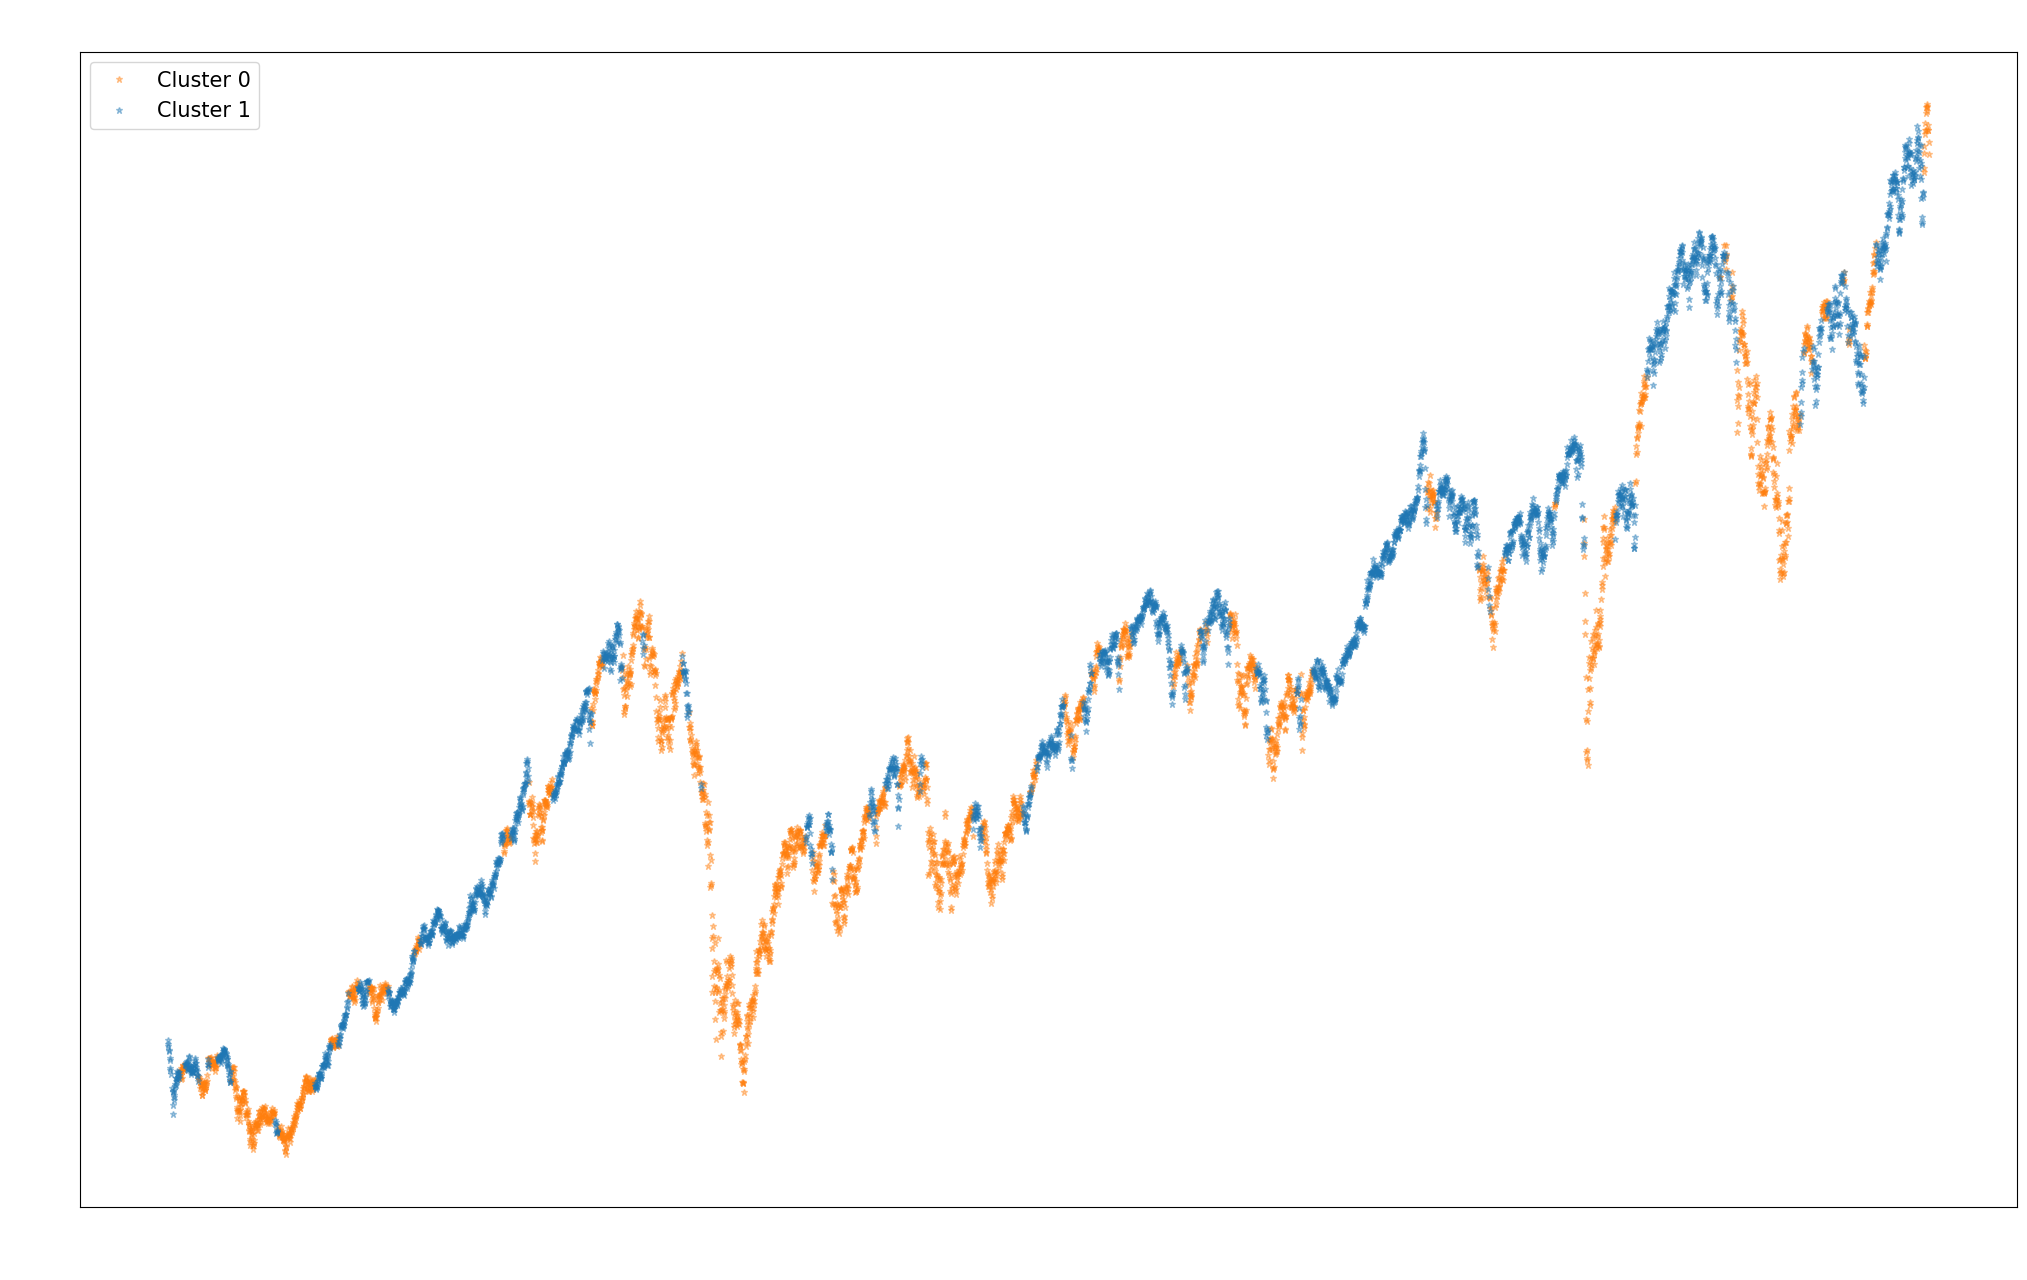

In [22]:
# Plot Hidden SVM states:
default = 'white'
fig = plt.figure(figsize=(25,15))
# Data:
hidden_svm_states = fig.add_subplot(111)
plt.plot_date(etf.index[hmm_state_0_cluster],etf['Adj Close'][hmm_state_0_cluster], marker='*', ms=5, alpha=0.4, color='C1', label='Cluster 0')
plt.plot_date(etf.index[hmm_state_1_cluster],etf['Adj Close'][hmm_state_1_cluster], marker='*', ms=5, alpha=0.4, color='C0',label='Cluster 1')
# Aesthetic adjustments:
hidden_svm_states.set_title('SVM Clusters', fontsize=30, color=default)
hidden_svm_states.set_xlabel("Date", fontsize=20, color=default)
hidden_svm_states.set_ylabel("Closing Price", fontsize=20, color=default)
hidden_svm_states.tick_params(axis='both', labelsize=15, colors=default)
hidden_svm_states.legend(loc='upper left', fontsize=15)
# Generate and save graph:
plt.savefig('hmm_svm_graph.png')
plt.show()